In [2]:
import pandas as pd
import numpy as np
import random
from scipy.stats import bernoulli
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import (T5ForConditionalGeneration,
                          T5Tokenizer)
from datasets import Dataset

device = torch.device("cuda:1")
random.seed(42)

In [3]:
df = pd.read_csv('data/preprocessed.csv', lineterminator='\n')

df = df.sort_values(by=['SUBJECT_ID','HADM_ID','CHARTDATE'])\
                .groupby(['SUBJECT_ID','HADM_ID'])\
                .head(1)
df = df[['SUBJECT_ID','ETHNICITY',
         'DIAGNOSIS','TEXT','apsiii']].reset_index(drop=True)
                
idx_white = random.sample(list(df.loc[df.ETHNICITY=='WHITE'].index), 
              df.loc[df.ETHNICITY=='BLACK'].shape[0])
df = pd.concat([df.loc[idx_white], 
                df.loc[df.ETHNICITY=='BLACK']]).reset_index(drop=True)

dataset = Dataset.from_pandas(df, split='train')
dataloader = DataLoader(dataset, batch_size=16)



In [4]:
# Load debiased GAN, only keep the encoder
model = T5ForConditionalGeneration.from_pretrained("results/gan/model-1-final")
model_enc = model.encoder
del model
model_enc.to(device)

tokenizer = T5Tokenizer.from_pretrained("t5-small",
                                            output_scores=True,
                                            output_hidden_states=True,
                                            model_max_length=512)

In [8]:
def encode(examples, tokenizer):
    inputs = examples['TEXT']  
    tokenized_inputs = tokenizer(inputs,
                                 return_tensors='pt',
                                 max_length=512,
                                 truncation=True,
                                 padding=True)
    model_inputs = {}
    model_inputs['input_ids']      = tokenized_inputs['input_ids']
    model_inputs['attention_mask'] = tokenized_inputs['attention_mask']
    return model_inputs, examples['ETHNICITY'], examples['apsiii']


In [14]:
def evaluate(model, dataloader, tokenizer):
    result = []
    race_lst = []
    apsiii_lst = []
    with torch.no_grad():
        for batch in dataloader:
            inputs, race, apsiii = encode(batch, tokenizer)
            output = model(input_ids      = inputs['input_ids'].to(device),
                           attention_mask = inputs['attention_mask'].to(device))
            result.append(output.last_hidden_state.cpu())
            race_lst.append(race)
            apsiii_lst.append(apsiii)
    return result, race_lst, apsiii_lst


In [15]:
result, race_lst, apsiii_lst = evaluate(model_enc, dataloader, tokenizer)

In [16]:
result = torch.vstack(result)
race_lst = list(itertools.chain.from_iterable(race_lst))
apsiii_lst = torch.cat(apsiii_lst).numpy()
result_mean = result.mean(dim=1)

In [17]:
idx_white, idx_black = np.where(np.array(race_lst)=='WHITE')[0], np.where(np.array(race_lst)=='BLACK')[0]

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
cs_white = cosine_similarity(result_mean[idx_white].numpy(),
                             result_mean[idx_white].numpy())
white_vals = cs_white[np.triu_indices(cs_white.shape[0])]

cs_black = cosine_similarity(result_mean[idx_black].numpy(),
                             result_mean[idx_black].numpy())
black_vals = cs_black[np.triu_indices(cs_black.shape[0])]

In [20]:
cs_mix = cosine_similarity(result_mean[idx_white].numpy(),
                           result_mean[idx_black].numpy())
mix_vals = cs_mix.flatten()

(array([6.000000e+00, 1.400000e+01, 1.180000e+02, 3.650000e+02,
        9.440000e+02, 2.110000e+03, 4.115000e+03, 7.664000e+03,
        1.380900e+04, 2.272200e+04, 3.485200e+04, 4.812300e+04,
        6.346000e+04, 7.743600e+04, 9.160300e+04, 1.040220e+05,
        1.148580e+05, 1.260390e+05, 1.354120e+05, 1.457850e+05,
        1.545290e+05, 1.614160e+05, 1.692850e+05, 1.749930e+05,
        1.821830e+05, 1.876120e+05, 1.953660e+05, 2.038510e+05,
        2.121520e+05, 2.210170e+05, 2.277360e+05, 2.340520e+05,
        2.372030e+05, 2.416740e+05, 2.467580e+05, 2.564710e+05,
        2.689030e+05, 2.886770e+05, 3.156770e+05, 3.547550e+05,
        4.093010e+05, 4.926000e+05, 6.109500e+05, 8.124290e+05,
        1.229687e+06, 2.139222e+06, 3.424637e+06, 2.458517e+06,
        2.051020e+05, 1.619400e+04]),
 array([0.03442814, 0.05373959, 0.07305104, 0.09236249, 0.11167394,
        0.1309854 , 0.15029685, 0.1696083 , 0.18891975, 0.2082312 ,
        0.22754265, 0.24685411, 0.26616555, 0.285477  , 0.

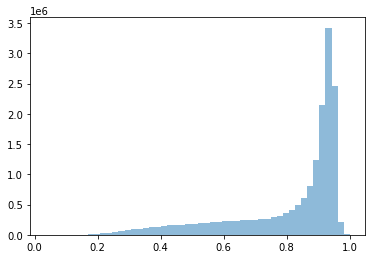

In [21]:
plt.hist(np.concatenate([white_vals, black_vals]), alpha=0.5, bins=50)

(array([6.000000e+00, 2.300000e+01, 1.000000e+02, 3.440000e+02,
        1.018000e+03, 2.087000e+03, 4.066000e+03, 7.673000e+03,
        1.385900e+04, 2.295100e+04, 3.443800e+04, 4.842700e+04,
        6.300200e+04, 7.824400e+04, 9.168400e+04, 1.035300e+05,
        1.152850e+05, 1.263540e+05, 1.357870e+05, 1.452790e+05,
        1.547680e+05, 1.625150e+05, 1.698730e+05, 1.751170e+05,
        1.817920e+05, 1.880840e+05, 1.957890e+05, 2.040000e+05,
        2.116570e+05, 2.206480e+05, 2.280610e+05, 2.334160e+05,
        2.376270e+05, 2.419900e+05, 2.470130e+05, 2.555080e+05,
        2.689050e+05, 2.890870e+05, 3.163960e+05, 3.544820e+05,
        4.112750e+05, 4.925870e+05, 6.105310e+05, 8.140070e+05,
        1.231968e+06, 2.140767e+06, 3.435274e+06, 2.447022e+06,
        2.003890e+05, 7.539000e+03]),
 array([0.03459753, 0.05390557, 0.07321361, 0.09252165, 0.1118297 ,
        0.13113774, 0.15044577, 0.16975382, 0.18906187, 0.20836991,
        0.22767796, 0.24698599, 0.26629403, 0.28560206, 0.

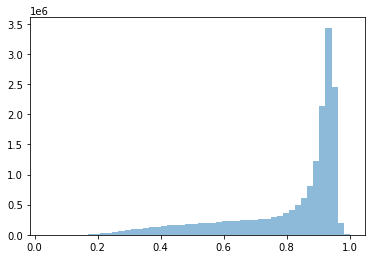

In [22]:
plt.hist(mix_vals, alpha=0.5, bins=50)

In [23]:
from scipy.spatial.distance import pdist

In [24]:


dist_apsiii_all = np.abs(apsiii_lst - apsiii_lst[:, None])
dist_cs_all = cosine_similarity(result_mean.numpy(), result_mean.numpy())

dist_apsiii_all = dist_apsiii_all[np.triu_indices(dist_apsiii_all.shape[0])]
dist_cs_all     = dist_cs_all[np.triu_indices(dist_cs_all.shape[0])]

In [25]:
idx = random.sample(range(len(dist_cs_all)), 10000)



In [26]:
np.corrcoef(dist_apsiii_all, dist_cs_all)

array([[ 1.        , -0.01629392],
       [-0.01629392,  1.        ]])

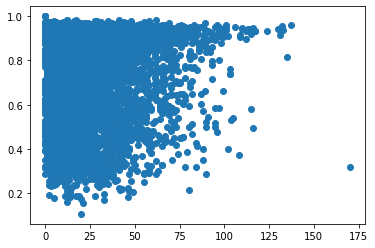

In [27]:
plt.scatter(dist_apsiii_all[idx], dist_cs_all[idx])